In [1]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys

import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [2]:
%pwd

'/Users/gryv9001/code/nielsen/covid_leading_indicators'

In [3]:
SCRIPT_PATH='./scripts'
module_path = os.path.abspath(os.path.join(SCRIPT_PATH))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
%load_ext autoreload
%autoreload 2

In [9]:
from functions import pd_read_s3_multiple_parquets
from collections import namedtuple
from utils import read_deaths_data

In [13]:
df  =read_deaths_data()

In [15]:
ny_df = df[df.state == "NY"]

In [16]:
ny_df.head()

,countyFIPS,county,state,stateFIPS,date,deaths,new_deaths
1861,0,Statewide Unallocated,NY,36,2020-01-22,0,0.0
1862,1,New York City Unallocated/Probable,NY,36,2020-01-22,0,0.0
1863,36001,Albany County,NY,36,2020-01-22,0,0.0
1864,36003,Allegany County,NY,36,2020-01-22,0,0.0
1865,36005,Bronx County,NY,36,2020-01-22,0,0.0


In [17]:
ny_df.county.unique()

array(['Statewide Unallocated', 'New York City Unallocated/Probable',
       'Albany County', 'Allegany County', 'Bronx County',
       'Broome County', 'Cattaraugus County', 'Cayuga County',
       'Chautauqua County', 'Chemung County', 'Chenango County',
       'Clinton County', 'Columbia County', 'Cortland County',
       'Delaware County', 'Dutchess County', 'Erie County',
       'Essex County', 'Franklin County', 'Fulton County',
       'Genesee County', 'Greene County', 'Hamilton County',
       'Herkimer County', 'Jefferson County', 'Kings County',
       'Lewis County', 'Livingston County', 'Madison County',
       'Monroe County', 'Montgomery County', 'Nassau County',
       'New York County', 'Niagara County', 'Oneida County',
       'Onondaga County', 'Ontario County', 'Orange County',
       'Orleans County', 'Oswego County', 'Otsego County',
       'Putnam County', 'Queens County', 'Rensselaer County',
       'Richmond County', 'Rockland County', 'St. Lawrence County',
   

In [7]:
usa_df = pd.melt(
        usa_df,
        id_vars=["countyFIPS", "County Name", "State", "stateFIPS"],
        var_name="date",
        value_name="deaths",
    )
usa_df["date"] = pd.to_datetime(usa_df["date"])

In [8]:
usa_df.head()

,countyFIPS,County Name,State,stateFIPS,date,deaths
0,0,Statewide Unallocated,AL,1,2020-01-22,0
1,1001,Autauga County,AL,1,2020-01-22,0
2,1003,Baldwin County,AL,1,2020-01-22,0
3,1005,Barbour County,AL,1,2020-01-22,0
4,1007,Bibb County,AL,1,2020-01-22,0


In [51]:
result = usa_df.drop(["County Name", "State", "stateFIPS"], axis=1)
# dft = df.T
# dft["date"] = dft.index
# result = melt(dft, id_vars=["date"])
# result.columns = ["date", "brand", "sales"]
# print. (result)

result = result.T
result["date"] = result.index
result = pd.melt(result, id_vars=["date"])
result.columns = ["date",  "countyFIPS", "deaths"]
result.tail()

,date,countyFIPS,deaths
380200,5/14/20,3194,0
380201,5/15/20,3194,0
380202,5/16/20,3194,0
380203,5/17/20,3194,0
380204,5/18/20,3194,0


In [41]:
result = usa_df.T
# usa_df_t["date"] = usa_df_t.index
# result = pd.melt(usa_df_t, id_vars=["date"])
#result.columns = ["date",  "countyFIPS", "County Name","State", "StateFIPS"]
result

,0,1,2,3,4,5,6,7,8,9,...,3185,3186,3187,3188,3189,3190,3191,3192,3193,3194
countyFIPS,0,1001,1003,1005,1007,1009,1011,1013,1015,1017,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
County Name,Statewide Unallocated,Autauga County,Baldwin County,Barbour County,Bibb County,Blount County,Bullock County,Butler County,Calhoun County,Chambers County,...,Niobrara County,Park County,Platte County,Sheridan County,Sublette County,Sweetwater County,Teton County,Uinta County,Washakie County,Weston County
State,AL,AL,AL,AL,AL,AL,AL,AL,AL,AL,...,WY,WY,WY,WY,WY,WY,WY,WY,WY,WY
stateFIPS,1,1,1,1,1,1,1,1,1,1,...,56,56,56,56,56,56,56,56,56,56
1/22/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5/14/20,0,4,8,1,1,0,1,8,3,22,...,0,0,0,0,0,0,1,0,0,0
5/15/20,0,4,8,1,1,0,1,9,3,22,...,0,0,0,0,0,0,1,0,0,0
5/16/20,0,4,8,1,1,0,1,9,3,22,...,0,0,0,0,0,0,1,0,0,0
5/17/20,0,4,8,1,1,1,1,9,3,22,...,0,0,0,0,0,0,1,0,0,0


In [38]:
usa_df[(usa_df["County Name"] == "Teton County") & (usa_df["State"] == "WY")].columns

Index(['countyFIPS', 'County Name', 'State', 'stateFIPS', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '5/9/20', '5/10/20', '5/11/20', '5/12/20', '5/13/20', '5/14/20',
       '5/15/20', '5/16/20', '5/17/20', '5/18/20'],
      dtype='object', length=122)

In [63]:
file_name="./data/cases_and_deaths_dmas"
df = pd.read_parquet(file_name)

In [64]:
df.head()

,date,state,state_abbreviation,county_fips,population,cases,cases_norm,deaths,deaths_norm,fips_id,county,dma_id,dma_name,zip
0,2020-03-12,Virginia,VA,760.0,230436,0,0.0,0,0.0,51760,Richmond City,556,RICHMOND-PETERSBURG,23298
1,2020-03-12,Virginia,VA,760.0,230436,0,0.0,0,0.0,51760,Richmond City,556,RICHMOND-PETERSBURG,23295
2,2020-03-12,Virginia,VA,760.0,230436,0,0.0,0,0.0,51760,Richmond City,556,RICHMOND-PETERSBURG,23293
3,2020-03-12,Virginia,VA,760.0,230436,0,0.0,0,0.0,51760,Richmond City,556,RICHMOND-PETERSBURG,23292
4,2020-03-12,Virginia,VA,760.0,230436,0,0.0,0,0.0,51760,Richmond City,556,RICHMOND-PETERSBURG,23291


In [65]:
df.county.unique()

array(['Richmond City', 'Roanoke City', 'Salem', ..., 'Wythe',
       'Fairfax City', 'Franklin City'], dtype=object)

In [66]:
dma_501 = df[df["dma_id"] == 501]

In [67]:
dma_501.dtypes

date                   object
state                  object
state_abbreviation     object
county_fips           float64
population              int64
cases                   int64
cases_norm            float64
deaths                  int64
deaths_norm           float64
fips_id                 int64
county                 object
dma_id                  int64
dma_name               object
zip                     int64
dtype: object

In [68]:
dma_501["date"] =  pd.to_datetime(dma_501["date"], format='%Y-%m-%d')

/Users/gryv9001/miniconda3/envs/dsai37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [69]:
dma_501 = dma_501.set_index("date")
dma_501.sort_index(inplace=True)

In [70]:
dma_501.county.unique()

array(['Fairfield', 'Orange', 'New York', 'Queens', 'Putnam', 'Nassau',
       'Ulster', 'Westchester', 'Sullivan', 'Pike', 'Suffolk', 'Rockland',
       'Richmond', 'Hunterdon', 'Middlesex', 'Essex', 'Hudson',
       'Monmouth', 'Morris', 'Bergen', 'Dutchess', 'Bronx', 'Union',
       'Warren', 'Kings', 'Ocean', 'Passaic', 'Sussex', 'Somerset'],
      dtype=object)

In [71]:
ny_dma_501 = dma_501[dma_501["county"] == "New York"]
ny_dma_501

,state,state_abbreviation,county_fips,population,cases,cases_norm,deaths,deaths_norm,fips_id,county,dma_id,dma_name,zip
date,,,,,,,,,,,,,
2020-01-22,New York,NY,61.0,8336817,0,0.000000,0,0.000000,36061,New York,501,NEW YORK,10001
2020-01-22,New York,NY,61.0,8336817,0,0.000000,0,0.000000,36061,New York,501,NEW YORK,10002
2020-01-22,New York,NY,61.0,8336817,0,0.000000,0,0.000000,36061,New York,501,NEW YORK,10003
2020-01-22,New York,NY,61.0,8336817,0,0.000000,0,0.000000,36061,New York,501,NEW YORK,10028
2020-01-22,New York,NY,61.0,8336817,0,0.000000,0,0.000000,36061,New York,501,NEW YORK,10029
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-17,New York,NY,61.0,8336817,192593,2310.150265,20720,248.536102,36061,New York,501,NEW YORK,10048
2020-05-17,New York,NY,61.0,8336817,192593,2310.150265,20720,248.536102,36061,New York,501,NEW YORK,10047
2020-05-17,New York,NY,61.0,8336817,192593,2310.150265,20720,248.536102,36061,New York,501,NEW YORK,10046


In [112]:
ny_dma_501["diff_cases"] = ny_dma_501["cases"].diff()

/Users/gryv9001/miniconda3/envs/dsai37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [113]:
ny_dma_501.dropna(inplace=True)

/Users/gryv9001/miniconda3/envs/dsai37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


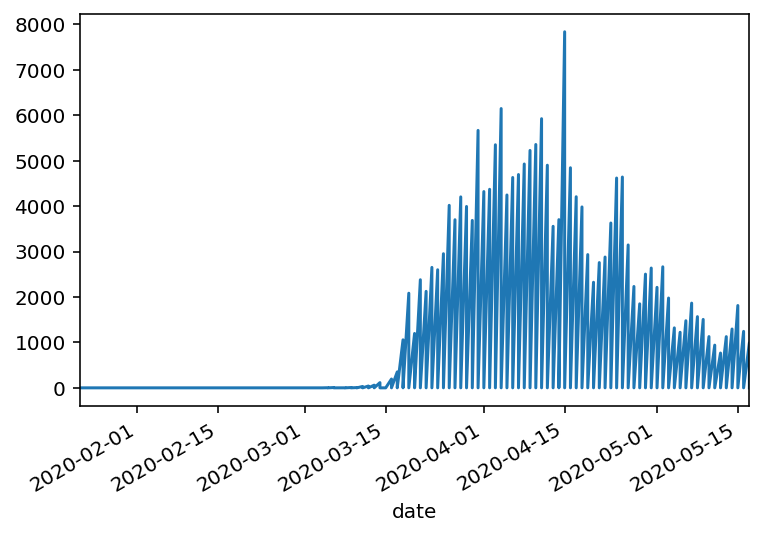

In [114]:
ny_dma_501["diff_cases"].plot()

In [115]:
population = ny_dma_501["population"][0]
population

8336817

In [116]:
p_delay = ny_dma_501["diff_cases"]/population
p_delay

date
2020-01-22    0.0
2020-01-22    0.0
2020-01-22    0.0
2020-01-22    0.0
2020-01-22    0.0
             ... 
2020-05-17    0.0
2020-05-17    0.0
2020-05-17    0.0
2020-05-17    0.0
2020-05-17    0.0
Name: diff_cases, Length: 18952, dtype: float64

In [117]:
probs = 1 - (p_delay.values)

In [118]:
np.arange(len(probs))

array([    0,     1,     2, ..., 18949, 18950, 18951])

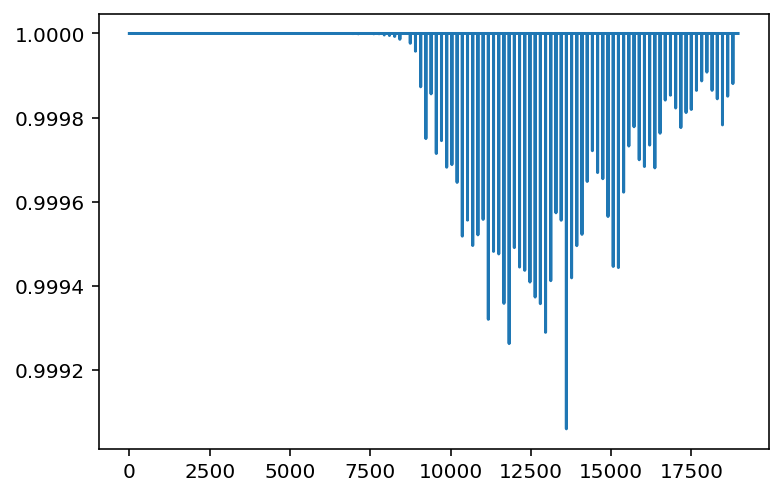

In [119]:
plt.plot(np.arange(len(probs)), probs)

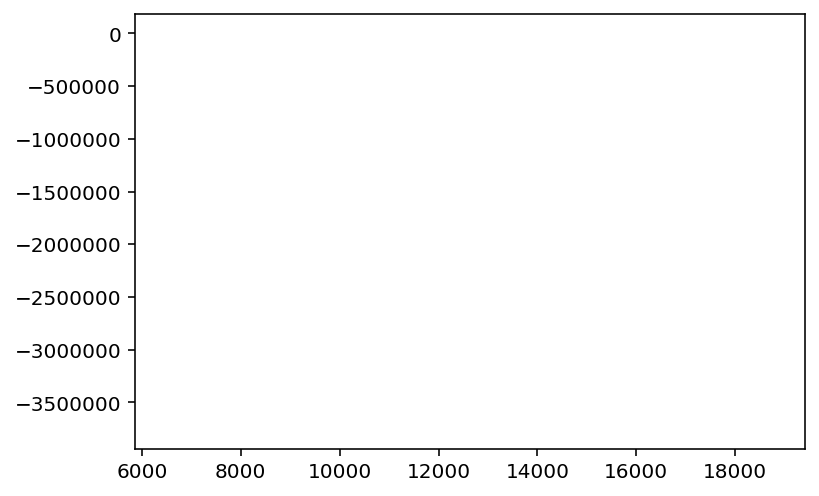

In [106]:
v = np.log(90)/ np.log(probs)
plt.plot(np.arange(len(v)), v)

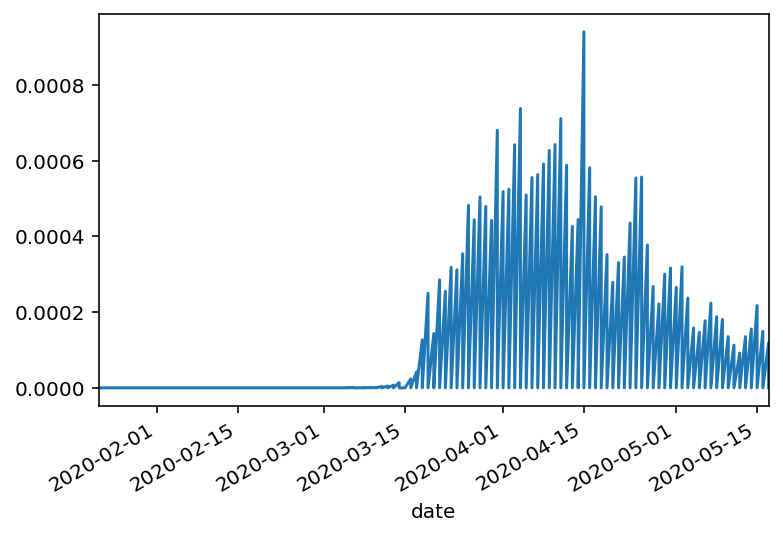

In [90]:
p_delay.plot()